**Name:** David Björelind

**EID:** 40107147

# CS4487 - Tutorial 9
## Face Detection with CNNs

In this tutorial you will train a CNN to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This mod

Next we will load keras and tensorflow (or Theano).
If you are using the lab PCs, then you need to use Theano. Also make sure to set the backend of Keras to use Theano.  See [here](https://keras.io/backend/#switching-from-one-backend-to-another).

In [2]:
# use TensorFlow backend
%env KERAS_BACKEND=tensorflow     
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
import keras

# select as appropriate
import tensorflow
# import theano

import logging
logging.basicConfig()
import struct

env: KERAS_BACKEND=tensorflow


/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [3]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [4]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.np_utils.to_categorical(trainY)
testYb  = keras.utils.np_utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,1,19,19))
testI  = asarray(imgdata['test']).reshape((944,1,19,19))

# cleanup memory
del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 1, 19, 19)
(944, 1, 19, 19)


In [24]:
print(trainY[1])
print(trainYb[1])

1
[0. 1.]


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


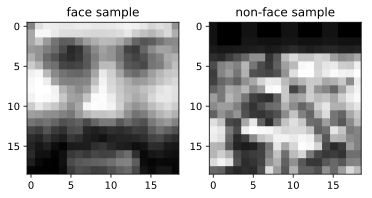

In [5]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

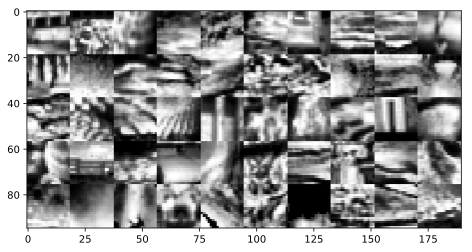

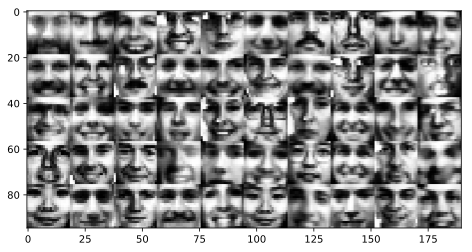

In [6]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [7]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape) ##TrainX, vTrainY = TrainY
print(validI.shape) ##TestX, validYb = TestY

(6279, 1, 19, 19)
(698, 1, 19, 19)


Here are some useful functions.

In [8]:
def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if 'acc' in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history['acc'], 'b', label="training acc ({:.4f})".format(history.history['acc'][-1]))
        ax2.plot(history.history['val_acc'], 'b--', label="validation acc ({:.4f})".format(history.history['val_acc'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

## 2. Detection using NN

Train a CNN to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, weight decay, and dropout rate to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

In [30]:
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
monitor='val_acc', # use validation accuracy for stopping
min_delta=0.0001, patience=5,
verbose=1, mode='auto')
callbacks_list = [earlystop]

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)
# build the network

nn = Sequential()
nn.add(Conv2D(10, (4,4), # channel, kernel size
strides=(3,3), # stride
activation='relu',
padding='same', # convolution padding
data_format='channels_first', # using channel-first format
input_shape=(1,19,19)))

nn.add(Flatten()) # flatten the feature map into a vector to apply Dense layers
nn.add(Dense(units=50, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True),
metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50,
                 callbacks=callbacks_list,
                 validation_data=validsetI, verbose=True)


Train on 6279 samples, validate on 698 samples
Epoch 1/100
6279/6279 [==============================] - 1s 170us/step - loss: 0.2100 - acc: 0.9064 - val_loss: 0.1651 - val_acc: 0.9456
Epoch 2/100
6279/6279 [==============================] - 1s 105us/step - loss: 0.0869 - acc: 0.9678 - val_loss: 0.0928 - val_acc: 0.9713
Epoch 3/100
6279/6279 [==============================] - 1s 111us/step - loss: 0.0658 - acc: 0.9750 - val_loss: 0.0855 - val_acc: 0.9756
Epoch 4/100
6279/6279 [==============================] - 1s 104us/step - loss: 0.0565 - acc: 0.9783 - val_loss: 0.0774 - val_acc: 0.9742
Epoch 5/100
6279/6279 [==============================] - 1s 113us/step - loss: 0.0499 - acc: 0.9823 - val_loss: 0.0711 - val_acc: 0.9613
Epoch 6/100
6279/6279 [==============================] - 1s 111us/step - loss: 0.0433 - acc: 0.9839 - val_loss: 0.0558 - val_acc: 0.9742
Epoch 7/100
6279/6279 [==============================] - 1s 109us/step - loss: 0.0385 - acc: 0.9861 - val_loss: 0.0492 - val_acc: 0

test accuracy: 0.6271186440677966


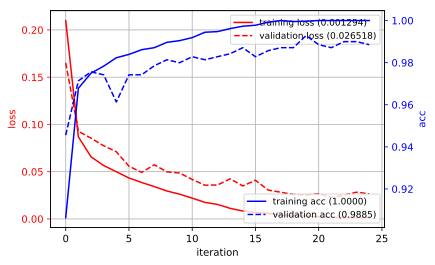

In [31]:
## Plotting the accuracy
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Getting an accuracy of 62% as a baseline test, let's see if I can get it any higher by adding some layers

In [84]:
# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
monitor='val_acc', # use validation accuracy for stopping
min_delta=0.0001, patience=5,
verbose=1, mode='auto')
callbacks_list = [earlystop]

# build the network
nn = Sequential()
nn.add(Conv2D(20, (5,5), strides=(2,2),
activation='relu', input_shape=(1,19,19),
padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (6,6), strides=(1,1), activation='relu',
padding='same', data_format='channels_first'))
nn.add(Conv2D(70, (6,6), strides=(2,2), activation='softmax',
padding='same', data_format='channels_first'))
nn.add(Dropout(rate=0.5, seed=44)) # dropout layer! (need to specify the seed)


nn.add(Flatten())
nn.add(Dense(units=25, activation='relu'))
#nn.add(Dropout(rate=0.5, seed=44)) # dropout layer! (need to specify the seed)
#nn.add(Dense(units=15, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=75, 
                 callbacks=callbacks_list, validation_data=validsetI, verbose=True)

Train on 6279 samples, validate on 698 samples
Epoch 1/100
6279/6279 [==============================] - 15s 2ms/step - loss: 0.6522 - acc: 0.6455 - val_loss: 0.6438 - val_acc: 0.6519
Epoch 2/100
6279/6279 [==============================] - 12s 2ms/step - loss: 0.6332 - acc: 0.6522 - val_loss: 0.5635 - val_acc: 0.6519
Epoch 3/100
6279/6279 [==============================] - 12s 2ms/step - loss: 0.2564 - acc: 0.8868 - val_loss: 0.1461 - val_acc: 0.9527
Epoch 4/100
6279/6279 [==============================] - 14s 2ms/step - loss: 0.1157 - acc: 0.9554 - val_loss: 0.0705 - val_acc: 0.9728
Epoch 5/100
6279/6279 [==============================] - 13s 2ms/step - loss: 0.0835 - acc: 0.9686 - val_loss: 0.0567 - val_acc: 0.9771
Epoch 6/100
6279/6279 [==============================] - 14s 2ms/step - loss: 0.0640 - acc: 0.9763 - val_loss: 0.0390 - val_acc: 0.9857
Epoch 7/100
6279/6279 [==============================] - 13s 2ms/step - loss: 0.0548 - acc: 0.9779 - val_loss: 0.0448 - val_acc: 0.9814
E

test accuracy: 0.7182203389830508


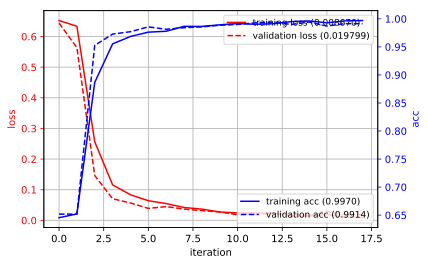

In [85]:
## Plotting the accuracy
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

This that I see improve accuracy:
    - Larger kernel size
    - Larger channel size
    - Smaller stride
    - Lower dropout rate
    

_How does the CNN compare to the linear and non-linear classifiers that you tried in Tutorial 4?_
- **INSERT YOUR ANSWER HERE**

CNN performs better than linear and non-linear classifiers. CNN is a more advanced method and therefore has the potential to perform better.

Just like non-linear is an improved version of linear, CNN is an improved version of the non-linear classifiers



## 3. Data Augmentation

Augmenting the training data with permutations is a good way to prevent NN from overfitting, and improving their generalization.  We will use the built-in `ImageDataGenerator` to apply geometric transformations.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [86]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [179]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation, 10
    width_shift_range=0.1,     # image shifting, 0.05
    height_shift_range=0.05,    # image shifting, 0.05
    shear_range=0.1,           # shear transformation, 0.05
    zoom_range=0.05,            # zooming, 0.05
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

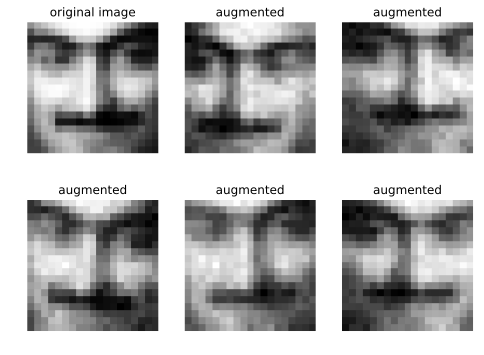

In [180]:
img = trainI[4]
imgs = [img[0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,1,19,19), [1], batch_size=1):
    imgs.append(augimg[0,0,:,:])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

Train your best CNN from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

In [186]:
### INSERT YOUR CODE HERE ###

# initialize random seed
random.seed(4487); tensorflow.set_random_seed(4487)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
monitor='val_acc', # use validation accuracy for stopping
min_delta=0.0001, patience=5,
verbose=1, mode='auto')
callbacks_list = [earlystop]

# build the network
nn = Sequential()
nn.add(Conv2D(20, (5,5), strides=(2,2), # 20, 5,5
activation='relu', input_shape=(1,19,19),
padding='same', data_format='channels_first'))
nn.add(Conv2D(40, (6,6), strides=(2,2), activation='relu', # 40, 6,6, 1,1
padding='same', data_format='channels_first'))
nn.add(Conv2D(70, (6,6), strides=(2,2), activation='softmax', # 70, 6,6
padding='same', data_format='channels_first'))
nn.add(Dropout(rate=0.5, seed=44)) # dropout layer! (need to specify the seed)


nn.add(Flatten())
nn.add(Dense(units=25, activation='relu'))
#nn.add(Dropout(rate=0.5, seed=44)) # dropout layer! (need to specify the seed)
#nn.add(Dense(units=15, activation='relu'))
nn.add(Dense(units=2, activation='softmax'))

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), metrics=['accuracy'])

history = nn.fit_generator(datagen.flow(vtrainI, vtrainYb, batch_size=50), # data from generator 
                           steps_per_epoch=len(vtrainI)/50, # should be number of batches per epoch
                           epochs=100, callbacks=callbacks_list, validation_data=validsetI, verbose=True)

Epoch 1/100
126/125 [==============================] - 9s 74ms/step - loss: 0.6555 - acc: 0.6445 - val_loss: 0.6501 - val_acc: 0.6519
Epoch 2/100
126/125 [==============================] - 6s 50ms/step - loss: 0.6472 - acc: 0.6515 - val_loss: 0.6451 - val_acc: 0.6519
Epoch 3/100
126/125 [==============================] - 6s 49ms/step - loss: 0.6450 - acc: 0.6509 - val_loss: 0.6253 - val_acc: 0.6519
Epoch 4/100
126/125 [==============================] - 6s 50ms/step - loss: 0.4173 - acc: 0.7985 - val_loss: 0.1830 - val_acc: 0.9298
Epoch 5/100
126/125 [==============================] - 6s 49ms/step - loss: 0.2262 - acc: 0.9116 - val_loss: 0.1710 - val_acc: 0.9370
Epoch 6/100
126/125 [==============================] - 6s 50ms/step - loss: 0.2086 - acc: 0.9129 - val_loss: 0.1633 - val_acc: 0.9384
Epoch 7/100
126/125 [==============================] - 7s 58ms/step - loss: 0.1858 - acc: 0.9258 - val_loss: 0.1535 - val_acc: 0.9470
Epoch 8/100
126/125 [==============================] - 8s 62ms

test accuracy: 0.8432203389830508


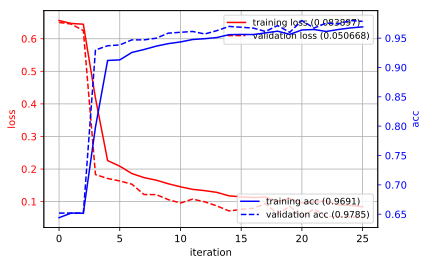

In [187]:
## Plotting the accuracy
plot_history(history)
predY = nn.predict_classes(testI, verbose=False)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

_Which type of augmentation improves the accuracy the most?  Why?  How does NN with data augmentation compare with your work in Tutorial 4?_ 
- **INSERT YOUR ANSWER HERE**

My thoughts are that if we make all the parameters in the Augmentaion algorithm zero, because that will take away the point of the augmentation. On the other hand, we can't skew the faces out of recognition. This will teach the classifier that a face is not a face.

The best classifier in Tutorial 4 was AdaBoost and I feel like the accuracy of NN without Augmentation and Dropout rate comes close to that of Adaboost when usen in Tutorial 4. However, with the improvements that Augmentation and Dropout brings, NN perfors better. This is most clear when using a larger data set and calculation time gets longer, AdaBoost lacks behind.

The single best type of augmentation seems to be width shift, this was without any other type of augmentation. But the best result is produced by a mix of some of the Augmentation types. However, the Augmentation quickly goes out of hand and produces an accuracy of 50% if you increase the parameters of the Augmentation too much,


# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [183]:
fname = "nasa-small.png"

(210, 480)


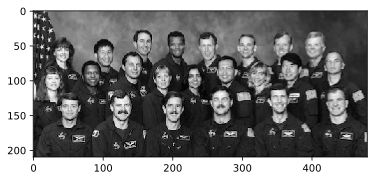

In [188]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [189]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], 1, psize[2], psize[3]))
print(patches2.shape)

# histogram equalize patches (improves contrast)
#newI = empty(patches2.shape)
#for i in range(patches2.shape[0]):
#    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])
newI = patches2

(5568, 1, 19, 19)


Now predict using your classifier.  The extracted images are in `newI`.

5568/5568 [==============================] - 2s 424us/step


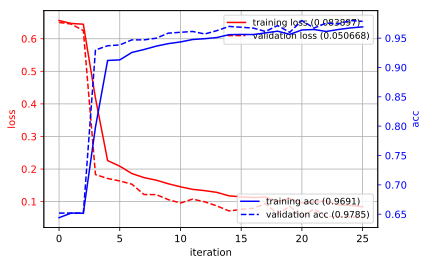

In [190]:
### YOUR CODE HERE
## Plotting the accuracy
#plot_history(history)
prednewY = nn.predict_classes(newI, verbose=True)
#acc = metrics.accuracy_score(testY, predY)
#print("test accuracy:", acc)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

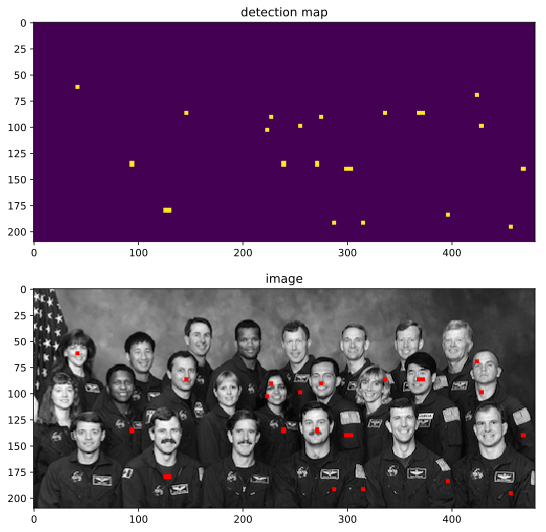

In [192]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do compared to the last version?_
- **INSERT YOUR ANSWER HERE**

The face detector in Tutorial 4 recognized about twice as many faces, but most of them were just randomly spread out throughout the picture.

This time, almost half of the red squares are actually located on faces. Although there are still many squares located elsewhere.

- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/8 of the training data. Try using more data to train it!